# TensorFlow Regression Example

## Creating Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 1 Million Points
x_data = np.linspace(0.0,10.0,1000000)

In [3]:
noise = np.random.randn(len(x_data))

In [4]:
# y = mx + b + noise_levels
b = 5

y_true =  (0.5 * x_data ) + 5 + noise

In [5]:
my_data = pd.concat([pd.DataFrame(data=x_data,columns=['X Data']),pd.DataFrame(data=y_true,columns=['Y'])],axis=1)

In [6]:
my_data.head()

,X Data,Y
0,0.00000,4.330181
1,0.00001,5.536234
2,0.00002,4.860358
3,0.00003,6.243151
4,0.00004,4.618661


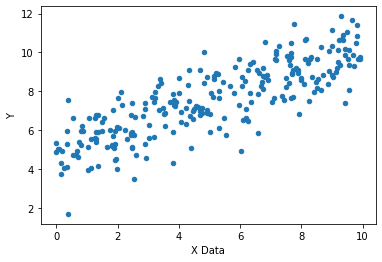

In [7]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')

# TensorFlow
## Batch Size

We will take the data in batches (1,000,000 points is a lot to pass in at once)

In [8]:
import tensorflow as tf

In [9]:
# Random 10 points to grab
batch_size = 8

** Variables **

In [10]:
m = tf.Variable(0.5)
b = tf.Variable(1.0)

** Placeholders **

In [11]:
xph = tf.placeholder(tf.float32,[batch_size])
yph = tf.placeholder(tf.float32,[batch_size])

** Graph **

In [12]:
y_model = m*xph + b

** Loss Function **

In [13]:
error = tf.reduce_sum(tf.square(yph-y_model))

** Optimizer **

In [14]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(error)

** Initialize Variables **

In [15]:
init = tf.global_variables_initializer()

### Session

In [16]:
with tf.Session() as sess:
    
    sess.run(init)
    
    batches = 1000
    
    for i in range(batches):
        
        rand_ind = np.random.randint(len(x_data),size=batch_size)
        
        feed = {xph:x_data[rand_ind],yph:y_true[rand_ind]}
        
        sess.run(train,feed_dict=feed)
        
    model_m,model_b = sess.run([m,b])

In [17]:
model_m

0.45150578

In [18]:
model_b

4.939635

### Results

In [19]:
y_hat = x_data * model_m + model_b

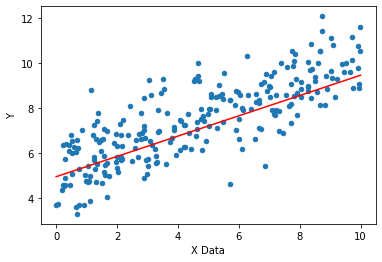

In [20]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')
plt.plot(x_data,y_hat,'r')

## tf.estimator API

Much simpler API for basic tasks like regression! We'll talk about more abstractions like TF-Slim later on.

In [21]:
feat_cols = [tf.feature_column.numeric_column('x',shape=[1])]

In [22]:
estimator = tf.estimator.LinearRegressor(feature_columns=feat_cols)

W0904 12:01:29.620113 140082342418240 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpba2wng2a


### Train Test Split

We haven't actually performed a train test split yet! So let's do that on our data now and perform a more realistic version of a Regression Task

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
x_train, x_eval, y_train, y_eval = train_test_split(x_data,y_true,test_size=0.3, random_state = 101)

In [25]:
print(x_train.shape)
print(y_train.shape)

print(x_eval.shape)
print(y_eval.shape)

(700000,)
(700000,)
(300000,)
(300000,)


### Set up Estimator Inputs

In [26]:
# Can also do .pandas_input_fn
input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train},y_train,batch_size=4,num_epochs=None,shuffle=True)

In [27]:
train_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train},y_train,batch_size=4,num_epochs=1000,shuffle=False)

In [28]:
eval_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_eval},y_eval,batch_size=4,num_epochs=1000,shuffle=False)

### Train the Estimator

In [29]:
estimator.train(input_fn=input_func,steps=1000)

W0904 12:01:40.311927 140082342418240 deprecation.py:323] From /home/kazzastic/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0904 12:01:40.330584 140082342418240 deprecation.py:323] From /home/kazzastic/anaconda3/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/inputs/queues/feeding_queue_runner.py:62: QueueRunner.__init__ (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
W0904 12:01:40.334268 140082342418240 deprecation.py:323] From /home/kazzastic/anaconda3/lib/python3.7/site-packages/tensorflow_estimator/python/estimator

### Evaluation

In [30]:
train_metrics = estimator.evaluate(input_fn=train_input_func,steps=1000)

W0904 12:01:54.851890 140082342418240 deprecation.py:323] From /home/kazzastic/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [31]:
eval_metrics = estimator.evaluate(input_fn=eval_input_func,steps=1000)

In [32]:
print("train metrics: {}".format(train_metrics))
print("eval metrics: {}".format(eval_metrics))

train metrics: {'average_loss': 1.1879752, 'label/mean': 7.535735, 'loss': 4.7519007, 'prediction/mean': 7.3646975, 'global_step': 1000}
eval metrics: {'average_loss': 1.1880592, 'label/mean': 7.489793, 'loss': 4.752237, 'prediction/mean': 7.324405, 'global_step': 1000}


### Predictions

In [33]:
input_fn_predict = tf.estimator.inputs.numpy_input_fn({'x':np.linspace(0,10,10)},shuffle=False)

In [34]:
list(estimator.predict(input_fn=input_fn_predict))

[{'predictions': array([4.2607546], dtype=float32)},
 {'predictions': array([4.946417], dtype=float32)},
 {'predictions': array([5.632079], dtype=float32)},
 {'predictions': array([6.317741], dtype=float32)},
 {'predictions': array([7.0034037], dtype=float32)},
 {'predictions': array([7.689065], dtype=float32)},
 {'predictions': array([8.374727], dtype=float32)},
 {'predictions': array([9.0603895], dtype=float32)},
 {'predictions': array([9.746052], dtype=float32)},
 {'predictions': array([10.431714], dtype=float32)}]

In [35]:
predictions = []# np.array([])
for x in estimator.predict(input_fn=input_fn_predict):
    predictions.append(x['predictions'])

In [36]:
predictions

[array([4.2607546], dtype=float32),
 array([4.946417], dtype=float32),
 array([5.632079], dtype=float32),
 array([6.317741], dtype=float32),
 array([7.0034037], dtype=float32),
 array([7.689065], dtype=float32),
 array([8.374727], dtype=float32),
 array([9.0603895], dtype=float32),
 array([9.746052], dtype=float32),
 array([10.431714], dtype=float32)]

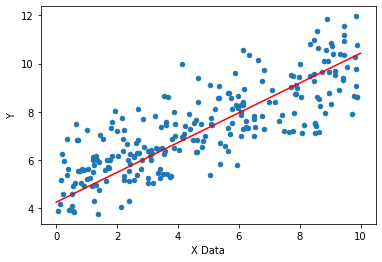

In [37]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')
plt.plot(np.linspace(0,10,10),predictions,'r')

# Great Job!